# Section1: Data Preparation
1. Import Libraries & Load datasets <br>
2. Data cleansing

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Load basket_sample csv into dataframe
df = pd.read_csv('baskets_sample.csv')
df.head()

,customer_number,purchase_time,basket_quantity,basket_spend,basket_categories
0,11911,2007-03-01 07:06:00,7,£3.09,3
1,4047,2007-03-01 07:13:00,9,£7.99,5
2,3571,2007-03-01 07:27:00,9,£37.06,6
3,4079,2007-03-01 07:34:00,11,£11.91,5
4,6063,2007-03-01 07:36:00,3,£1.45,1


In [3]:
#Check the data

print("The shape of the data:")
print("Number of Rows:", df.shape[0])
print("Number of Columns:",df.shape[1])
print("==========================")

print("Check if there is Missing values?")
print(df.isnull().sum())
print("==========================")

print("Data types in each columns")
print(df.dtypes)
print("==========================")

The shape of the data:
Number of Rows: 195547
Number of Columns: 5
Check if there is Missing values?
customer_number      0
purchase_time        0
basket_quantity      0
basket_spend         0
basket_categories    0
dtype: int64
Data types in each columns
customer_number       int64
purchase_time        object
basket_quantity       int64
basket_spend         object
basket_categories     int64
dtype: object


In [4]:
#Overview of the data 
df.describe()

,customer_number,basket_quantity,basket_categories
count,195547.000000,195547.000000,195547.000000
mean,7896.492899,8.955218,4.231990
std,4408.251411,9.510890,2.478016
min,14.000000,-11.000000,1.000000
25%,4323.000000,3.000000,2.000000
50%,7944.000000,6.000000,4.000000
75%,11324.000000,11.000000,6.000000
max,16316.000000,190.000000,16.000000


In [5]:
#Cleanse the data
#1.Remove £ sign & convert spend into float
df = df.replace('£','', regex=True)
df['basket_spend'] = df['basket_spend'].astype(float)


#2.Remove negative values of spend & set them as zero
df['basket_spend'] = df['basket_spend'].clip(lower=0).fillna(0)
df['basket_quantity'] = df['basket_quantity'].clip(lower=0).fillna(0)

In [6]:
df.describe()

,customer_number,basket_quantity,basket_spend,basket_categories
count,195547.000000,195547.000000,195547.000000,195547.000000
mean,7896.492899,8.955504,11.809666,4.231990
std,4408.251411,9.510536,13.020956,2.478016
min,14.000000,0.000000,0.000000,1.000000
25%,4323.000000,3.000000,4.280000,2.000000
50%,7944.000000,6.000000,8.130000,4.000000
75%,11324.000000,11.000000,14.480000,6.000000
max,16316.000000,190.000000,377.280000,16.000000


In [7]:
#Data preparation for feature engineering

#Labeling dates in the dataset
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

all_dates = (pd.to_datetime(df['purchase_time'])).apply(lambda x:x.date())
x = (all_dates.max() - all_dates.min()).days
print("The POS data collecting period contains", x , "days of data.")
print('Start date: {}'.format(all_dates.min()))
print('End date: {}'.format(all_dates.max()))


#Defineing snapshot date
snapshot_date = df['purchase_time'].max() + timedelta(days=1)
print(snapshot_date)

The POS data collecting period contains 183 days of data.
Start date: 2007-03-01
End date: 2007-08-31
2007-09-01 21:55:00


In [8]:
#Duplicate purchase_time columns to enable feature engineering 
# "purchase_time" is used to generate "Recency","Frequency" and "Length" features

df['purchase_time2'] = df['purchase_time']  
df['purchase_time3'] = df['purchase_time']

In [9]:
df.head()

,customer_number,purchase_time,basket_quantity,basket_spend,basket_categories,purchase_time2,purchase_time3
0,11911,2007-03-01 07:06:00,7,3.09,3,2007-03-01 07:06:00,2007-03-01 07:06:00
1,4047,2007-03-01 07:13:00,9,7.99,5,2007-03-01 07:13:00,2007-03-01 07:13:00
2,3571,2007-03-01 07:27:00,9,37.06,6,2007-03-01 07:27:00,2007-03-01 07:27:00
3,4079,2007-03-01 07:34:00,11,11.91,5,2007-03-01 07:34:00,2007-03-01 07:34:00
4,6063,2007-03-01 07:36:00,3,1.45,1,2007-03-01 07:36:00,2007-03-01 07:36:00


# <br>
# Section 2: Creating New Features
New features will be generated using existing features from "baskets_sample" and "lineitems_sample" datasets. <br>
Dataframe with new features are named "purchase_data", which is going to be utilised for clustering.<br>

In [10]:
#Generate new features based on existing columns
#Group by cusotmer_number

purchase_data = df.groupby(['customer_number']).agg({
        'purchase_time': lambda x: (snapshot_date - x.max()).days,
        'purchase_time2': 'count',
        'basket_spend': 'sum',
        'purchase_time3':lambda x: (x.max() - x.min()).days})


In [11]:
#Rename the columns with new feature names

purchase_data.rename(columns={'purchase_time': 'Recency',
                         'purchase_time2': 'Frequency',
                         'basket_spend': 'Monetary',   
                         'purchase_time3':'Length',}, inplace=True)

In [12]:
#Generate feature of  average_spend_shop 

purchase_data['Average_spend_shop'] = purchase_data['Monetary']/purchase_data['Frequency']

In [13]:
# Load lineitmes sample dataset

df2= pd.read_csv('lineitems_sample.csv')
df2.head()

,customer_number,purchase_time,product_id,category,quantity,spend
0,14577,2007-03-10 11:58:00,722653,GROCERY_FOOD,1,£1.39
1,7210,2007-03-22 10:53:00,696136,GROCERY_HEALTH_PETS,1,£4.25
2,3145,2007-03-26 11:17:00,139543,GROCERY_HEALTH_PETS,1,£0.50
3,2649,2007-03-12 16:05:00,34890,BAKERY,1,£0.57
4,859,2007-03-10 09:53:00,613984,BAKERY,1,£1.59


In [14]:
# Creat feature of  count_od_unique_product_id

count_product_id = df2.groupby('customer_number').product_id.nunique()
count_product_id = pd.DataFrame(count_product_id)

purchase_data = pd.concat([purchase_data,count_product_id],axis = 'columns')
purchase_data.rename(columns={'product_id': 'Count_of_unique_product_id'}, inplace=True)

In [15]:
#Take a look at the dataset
purchase_data.head()

,Recency,Frequency,Monetary,Length,Average_spend_shop,Count_of_unique_product_id
customer_number,,,,,,
14,2,56,675.72,180,12.066429,141
45,2,33,585.73,182,17.749394,313
52,3,59,222.18,174,3.765763,76
61,4,37,547.87,179,14.807297,245
63,8,48,293.34,175,6.111250,151


In [16]:
purchase_data.describe()

,Recency,Frequency,Monetary,Length,Average_spend_shop,Count_of_unique_product_id
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,9.120333,65.182333,769.781613,171.242000,14.805957,218.750000
std,20.938847,47.464717,552.984742,22.456733,11.160582,121.516911
min,1.000000,1.000000,7.280000,0.000000,1.456000,6.000000
25%,1.000000,32.000000,406.707500,172.000000,8.039984,135.000000
50%,3.000000,53.000000,627.170000,178.000000,11.770923,195.500000
75%,7.000000,86.000000,958.660000,181.000000,17.436190,278.000000
max,165.000000,374.000000,6588.650000,183.000000,152.621667,1106.000000


# <br>
# Section3: Data Summary & Exploration
1. Visualize the data distribution with histplot <br>
2. Explore correlation between data with scatter plots & heatmap <br>


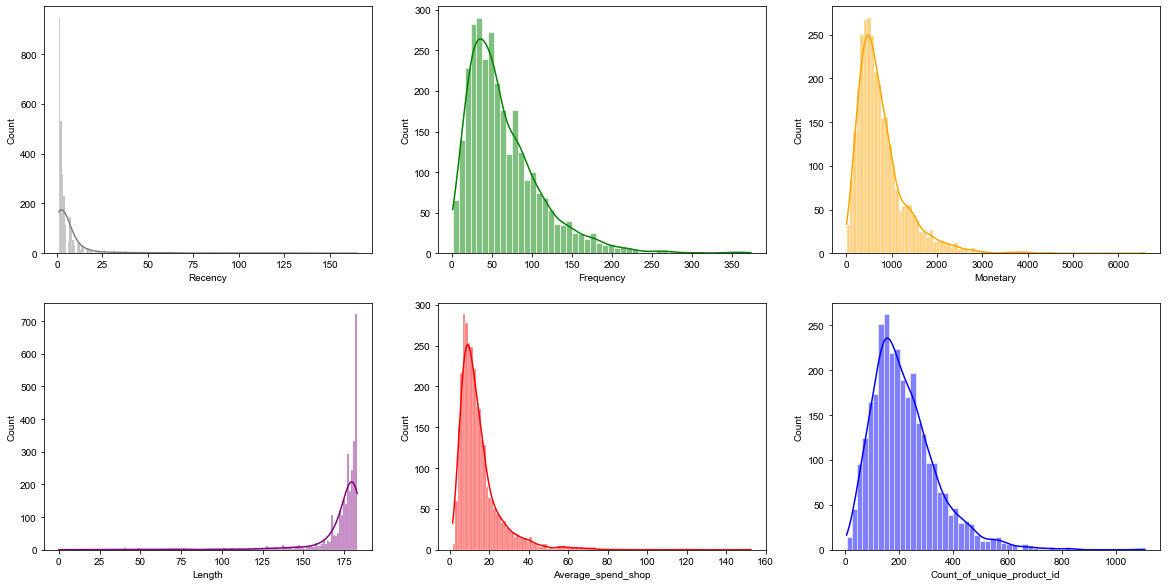

In [17]:
#Plot the data distribution of each feature

fig, axes = plt.subplots(2,3)
fig.set_size_inches(20,10)
sns.set_theme(style="darkgrid",palette="muted")
sns.histplot(data=purchase_data, x="Recency",kde=True,color = 'grey',ax=axes[0,0])
sns.histplot(data=purchase_data, x="Frequency",kde=True,color = 'green', ax=axes[0,1])
sns.histplot(data=purchase_data, x="Monetary",kde=True,color = 'orange', ax=axes[0,2])
sns.histplot(data=purchase_data, x="Length",kde=True,color = 'purple', ax=axes[1,0])
sns.histplot(data=purchase_data, x="Average_spend_shop",kde=True,color = 'red', ax=axes[1,1])
sns.histplot(data=purchase_data, x="Count_of_unique_product_id",kde=True,color = 'blue', ax=axes[1,2]);

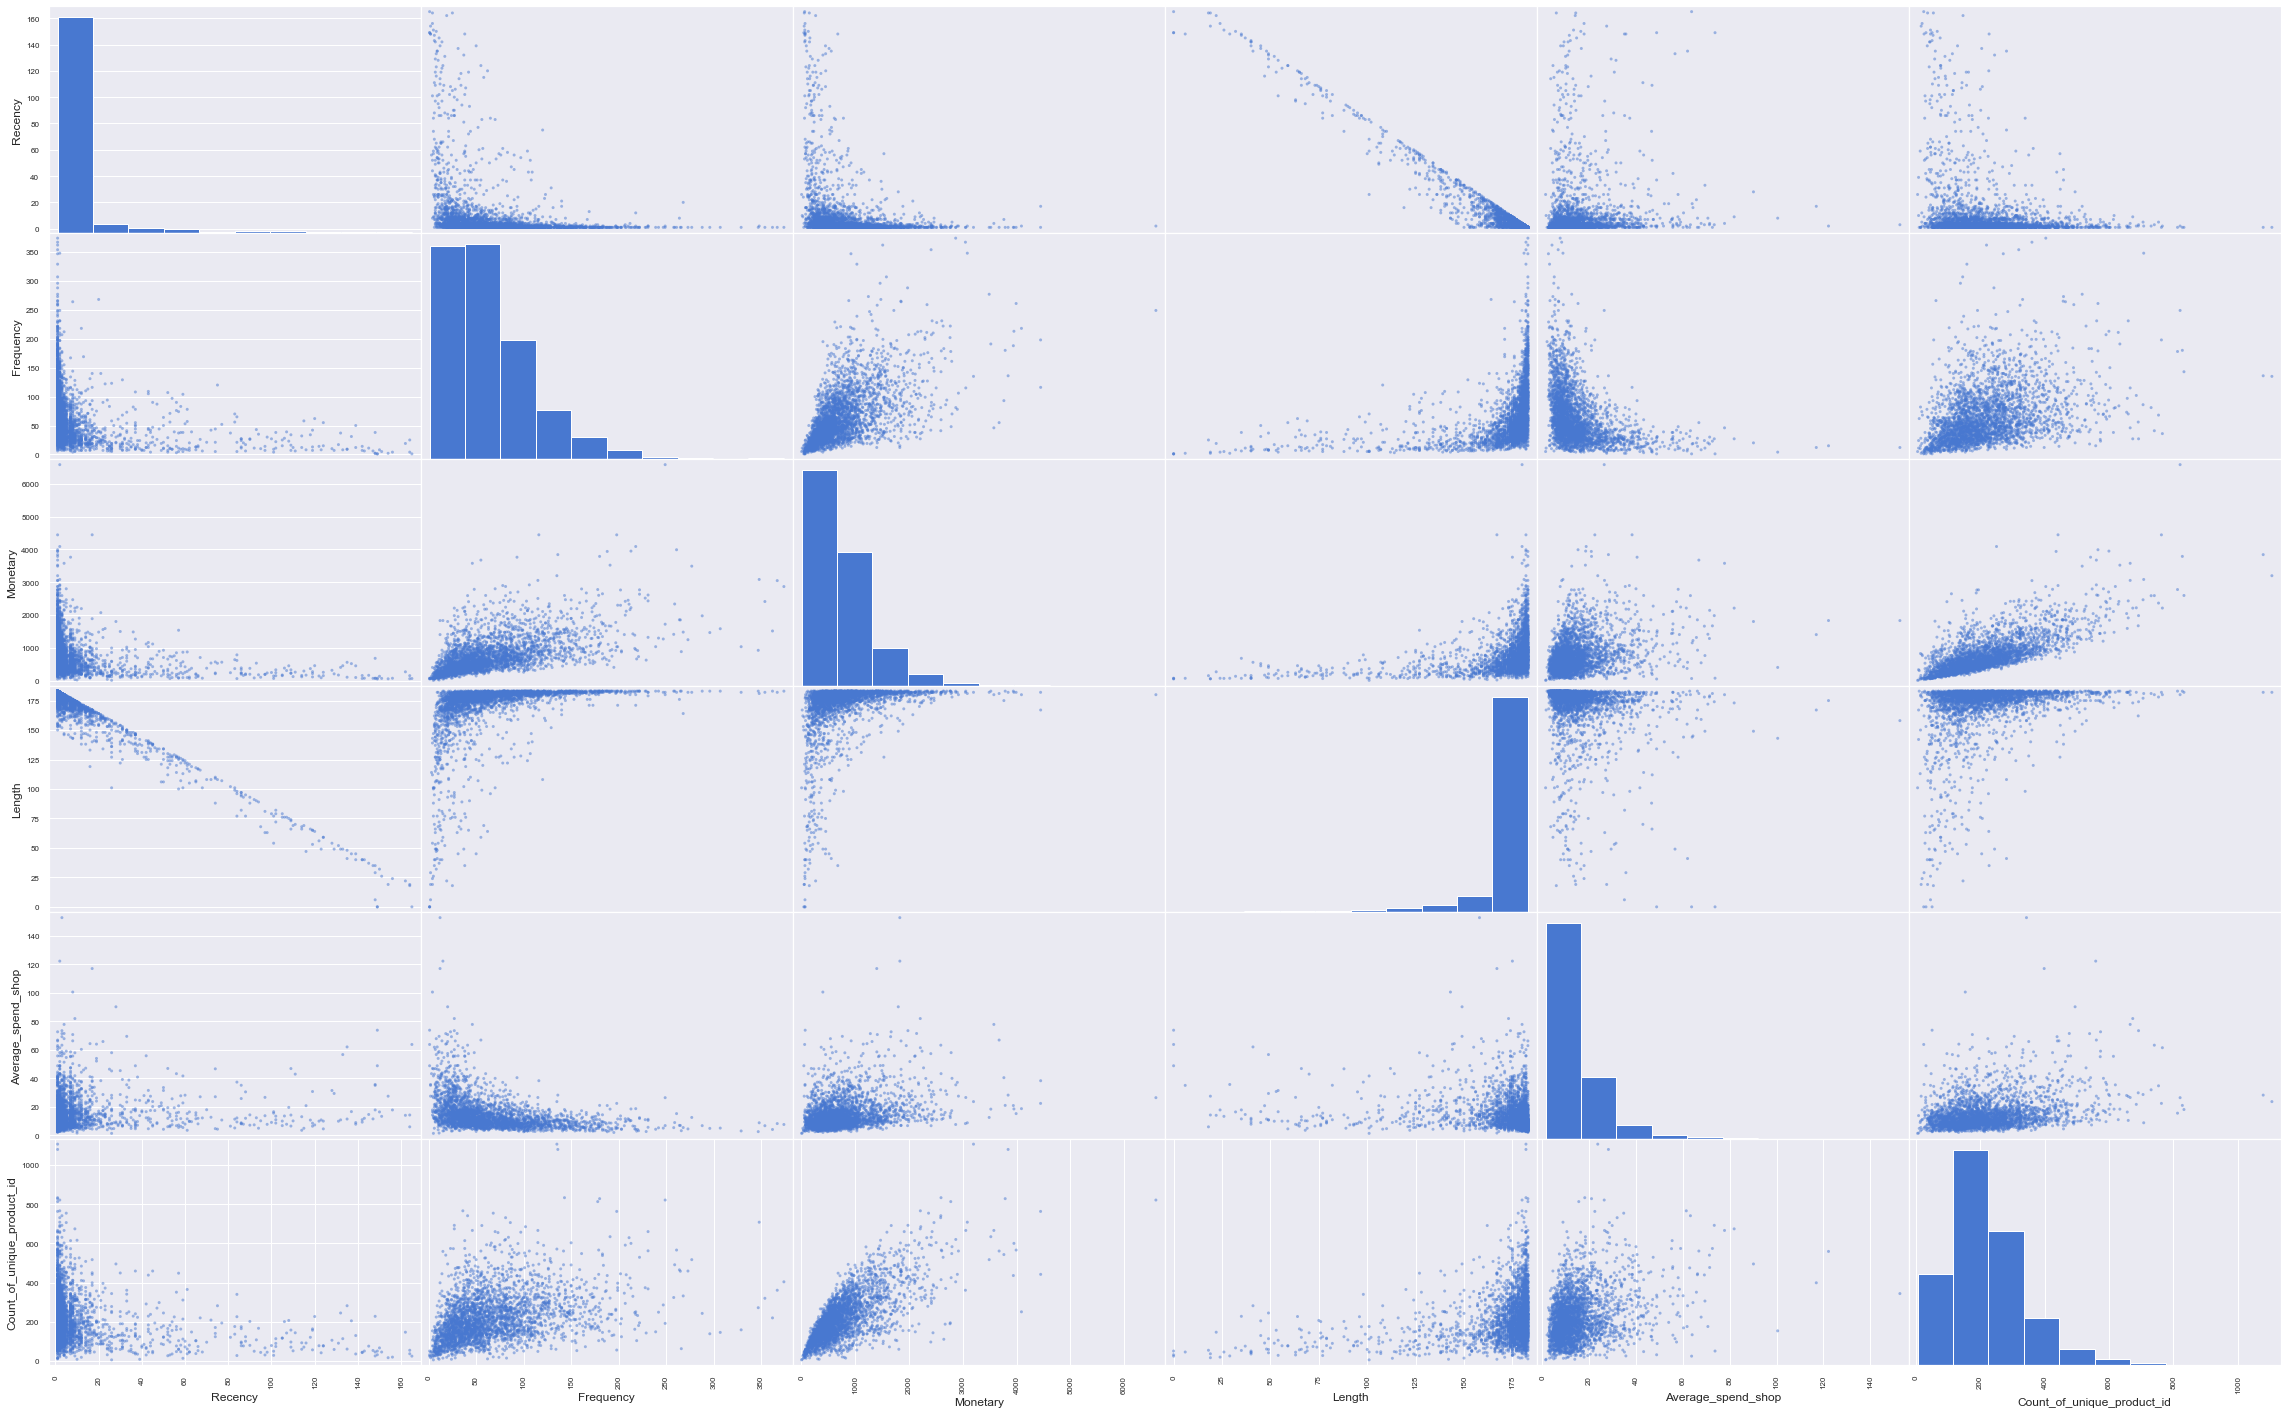

In [18]:
# Visulize the data correlation with scatter plot
scatter = pd.plotting.scatter_matrix(purchase_data,figsize = (40,25));

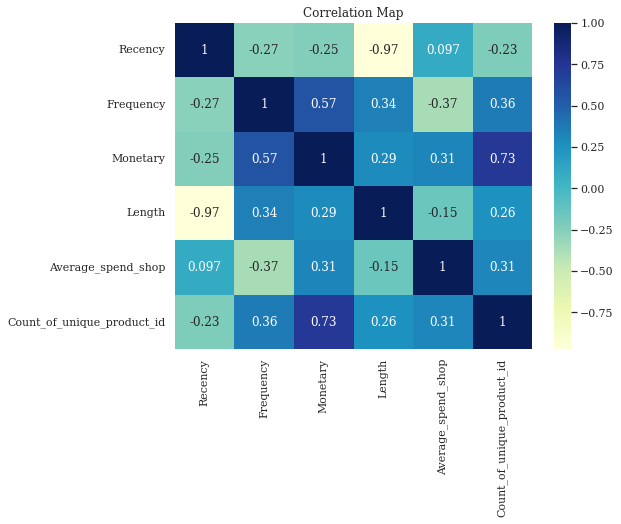

In [19]:
# Visulize the data correlation with heatmap

plt.rcParams['font.family'] = "serif"
plt.figure(figsize=(8,6))
corr = purchase_data.corr()
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.title('Correlation Map')
plt.show()

# <br>
# Section 4: Feature Engineering
1. Standardization <br>
2. Employment of PCA <br>

In [20]:
#Standarsize the data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(purchase_data)

scaled_df = pd.DataFrame(scaled, columns = purchase_data.columns)

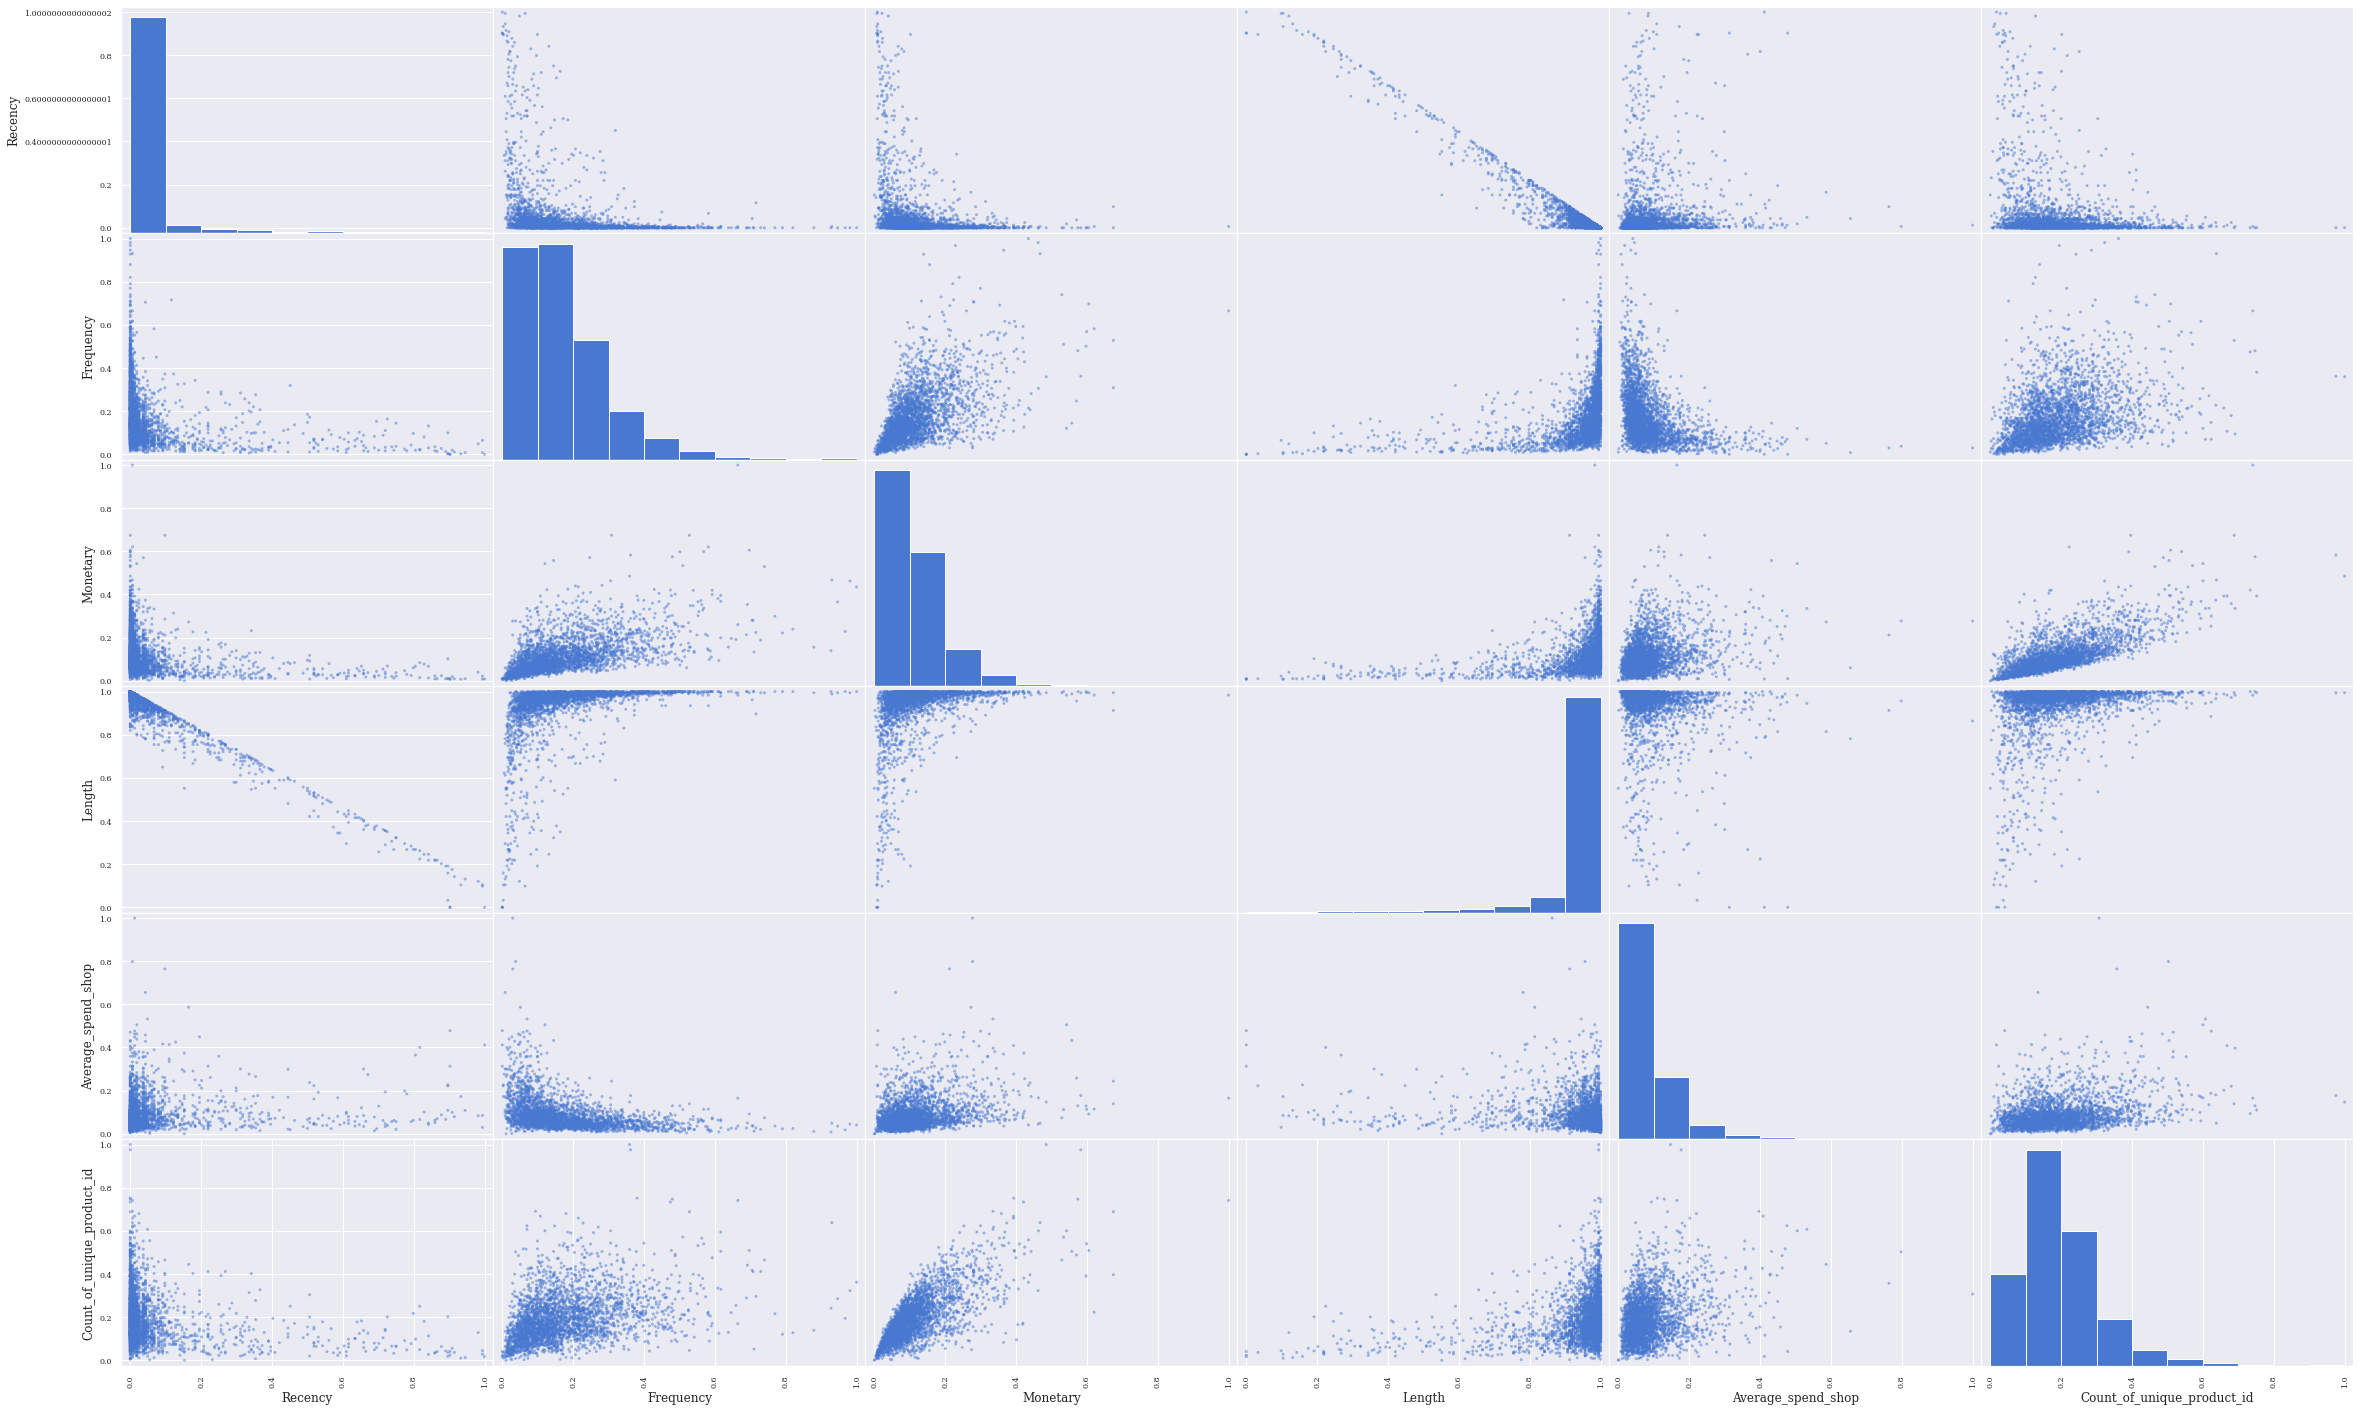

In [21]:
scatter = pd.plotting.scatter_matrix(scaled_df,figsize = (40,25));

In [22]:
scaled_df.describe()

,Recency,Frequency,Monetary,Length,Average_spend_shop,Count_of_unique_product_id
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.049514,0.172071,0.115858,0.935749,0.088313,0.193409
std,0.127676,0.127251,0.084023,0.122714,0.073830,0.110470
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.083110,0.060691,0.939891,0.043555,0.117273
50%,0.012195,0.139410,0.094189,0.972678,0.068236,0.172273
75%,0.036585,0.227882,0.144557,0.989071,0.105713,0.247273
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
from sklearn.decomposition import PCA

#to preserve 95% of data variance
pca = PCA(0.95)
pca.fit(scaled_df)

PCA(n_components=0.95)

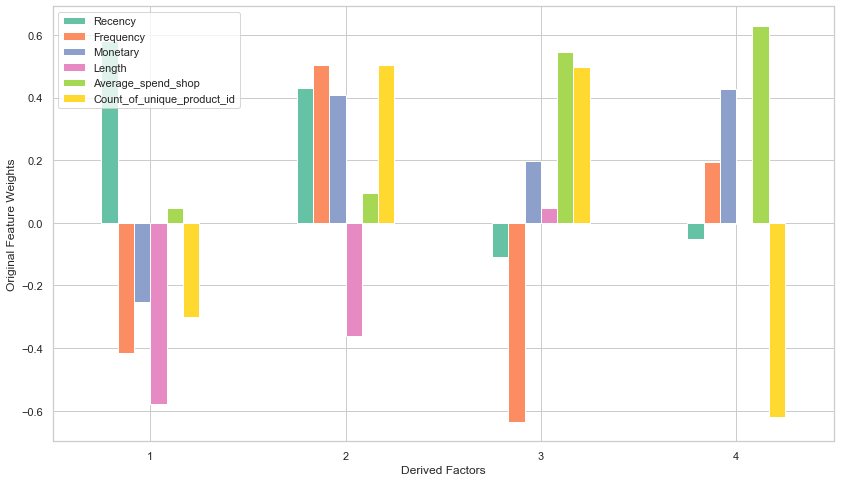

In [24]:
#Visualize PCA components

sns.set_theme(style="whitegrid",palette="Set2")

def display_factors(model, original_features):
    dimensions = range(1, len(model.components_) + 1)
    topics = pd.DataFrame(model.components_, columns = original_features)
    fig, ax = plt.subplots(figsize = (14,8))
    topics.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Original Feature Weights")
    ax.set_xlabel("Derived Factors")
    ax.set_xticklabels(dimensions, rotation=0)

display_factors(pca, purchase_data.columns)

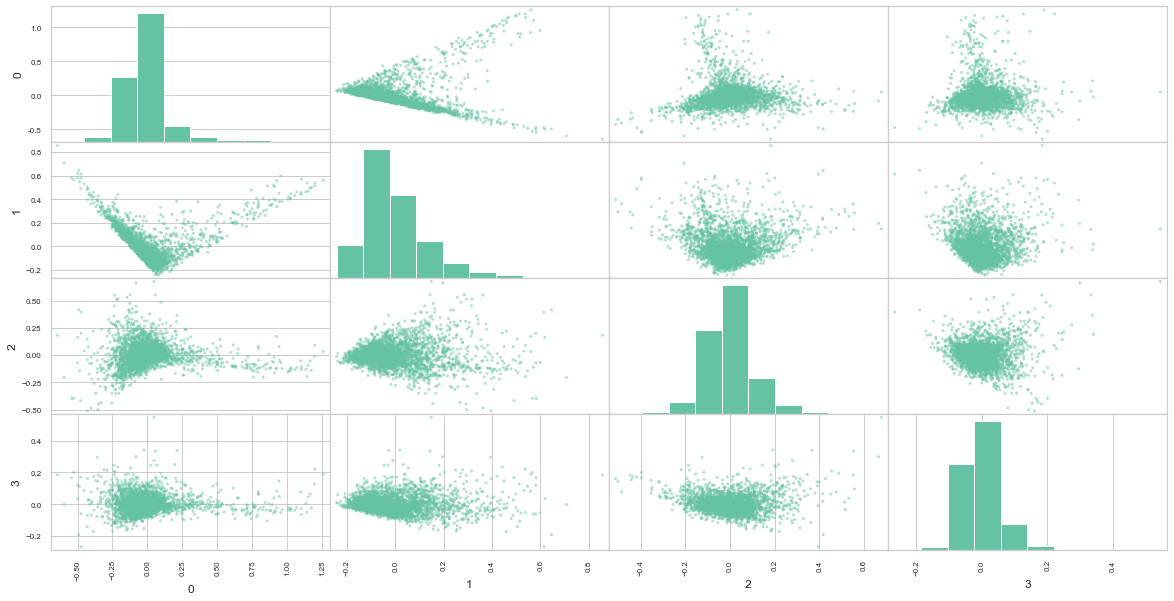

In [25]:
reduced_data = pca.transform(scaled_df)
reduced_data = pd.DataFrame(reduced_data)

scatter = pd.plotting.scatter_matrix(reduced_data, figsize = (20,10))

# <br>
# Section 5: Clustering

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Create range of clusters 
range_n_clusters = list(range(4,8))
print(range_n_clusters)

# Loop through clusters
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters = n_clusters).fit(reduced_data)
    preds = clusterer.predict(reduced_data)
    centers = clusterer.cluster_centers_

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    print("For n_clusters = {}. The average silhouette_score is : {})".format(n_clusters, score))
    

[4, 5, 6, 7]
For n_clusters = 4. The average silhouette_score is : 0.37491108680809504)
For n_clusters = 5. The average silhouette_score is : 0.38935044821462694)
For n_clusters = 6. The average silhouette_score is : 0.2934325659142074)
For n_clusters = 7. The average silhouette_score is : 0.29392355970362843)


For 5 clusters The average silhouette_score is : 0.38893143754943926


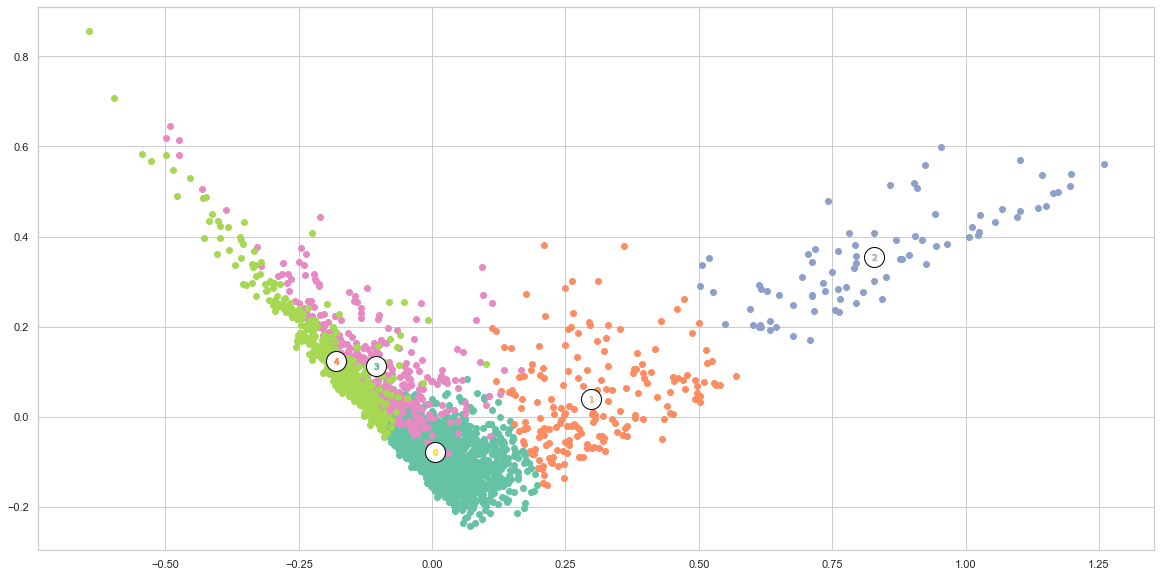

In [27]:
#final clustering solution
clusterer = KMeans(n_clusters=5,random_state = 120).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centres = clusterer.cluster_centers_

score = silhouette_score(reduced_data, preds, metric='euclidean')
print("For 5 clusters The average silhouette_score is :", score)

#Put the predictions into a pandas dataframe format
assignments = pd.DataFrame(preds, columns = ['Cluster'])
plot_data = pd.concat([assignments, reduced_data], axis = 1)


#Color the points based on assigned cluster 
plt.rcParams['figure.figsize'] = (20,10)

for i, c in plot_data.groupby('Cluster'):  
    plt.scatter(c[0], c[1])
    
#-- Plot where the cluster centers are
for i, c in enumerate(centres):
    plt.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', marker = 'o', s=400);
    plt.scatter(x = c[0], y = c[1], marker='${}$'.format(i), alpha = 1, s=40);

In [28]:
#Inverse scaled datapoints

scaled_centre = pca.inverse_transform(centres)
true_centres = scaler.inverse_transform(scaled_centre)

In [29]:
# Concate clustering results with original dataframe
purchase_data['Cluster'] = pd.Series(preds, index=purchase_data.index)

In [30]:
purchase_data.describe()

,Recency,Frequency,Monetary,Length,Average_spend_shop,Count_of_unique_product_id,Cluster
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,9.120333,65.182333,769.781613,171.242000,14.805957,218.750000,1.192333
std,20.938847,47.464717,552.984742,22.456733,11.160582,121.516911,1.633268
min,1.000000,1.000000,7.280000,0.000000,1.456000,6.000000,0.000000
25%,1.000000,32.000000,406.707500,172.000000,8.039984,135.000000,0.000000
50%,3.000000,53.000000,627.170000,178.000000,11.770923,195.500000,0.000000
75%,7.000000,86.000000,958.660000,181.000000,17.436190,278.000000,3.000000
max,165.000000,374.000000,6588.650000,183.000000,152.621667,1106.000000,4.000000



# <br>
# Section 6: Segmentation Results Analysis
<br>

In [31]:
for c, d in purchase_data.groupby('Cluster'):  
    print("Segment", c)
    display(d.describe())

Segment 0


,Recency,Frequency,Monetary,Length,Average_spend_shop,Count_of_unique_product_id,Cluster
count,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.0
mean,4.367615,49.367068,552.591756,175.929978,13.054331,174.818928,0.0
std,4.196785,23.514552,249.281167,6.289453,7.276700,67.661498,0.0
min,1.000000,6.000000,18.360000,146.000000,1.669091,9.000000,0.0
25%,1.000000,30.000000,374.927500,173.000000,8.022222,126.000000,0.0
50%,3.000000,47.000000,521.720000,178.000000,11.285238,171.000000,0.0
75%,6.000000,65.000000,697.542500,181.000000,15.760577,224.000000,0.0
max,26.000000,118.000000,1890.080000,183.000000,61.830000,347.000000,0.0


Segment 1


,Recency,Frequency,Monetary,Length,Average_spend_shop,Count_of_unique_product_id,Cluster
count,188.000000,188.00000,188.000000,188.000000,188.000000,188.000000,188.0
mean,38.696809,27.68617,382.691011,135.297872,18.401447,135.962766,1.0
std,16.317328,24.49233,283.059839,14.483869,13.812961,83.178332,0.0
min,7.000000,3.00000,7.280000,100.000000,1.456000,6.000000,1.0
25%,26.000000,10.00000,169.880000,125.000000,9.003711,73.750000,1.0
50%,37.000000,19.00000,294.555000,138.000000,14.949545,124.000000,1.0
75%,52.000000,38.00000,517.900000,147.000000,23.038659,175.250000,1.0
max,77.000000,120.00000,1536.300000,160.000000,100.482500,459.000000,1.0


Segment 2


,Recency,Frequency,Monetary,Length,Average_spend_shop,Count_of_unique_product_id,Cluster
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.0
mean,116.185185,20.111111,236.147037,61.407407,17.966368,102.592593,2.0
std,24.702789,16.652327,161.924766,26.328111,15.056726,66.171893,0.0
min,74.000000,1.000000,48.830000,0.000000,3.621875,17.000000,2.0
25%,95.000000,7.000000,115.900000,45.000000,8.671842,51.000000,2.0
50%,114.000000,14.000000,194.220000,66.000000,12.023333,80.000000,2.0
75%,137.000000,28.000000,314.910000,79.000000,19.643913,137.000000,2.0
max,165.000000,70.000000,784.760000,102.000000,73.750000,340.000000,2.0


Segment 3


,Recency,Frequency,Monetary,Length,Average_spend_shop,Count_of_unique_product_id,Cluster
count,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.0
mean,4.296104,61.020779,1447.025091,176.664935,28.579096,414.374026,3.0
std,5.123537,29.172165,615.911098,7.155959,17.391494,122.718854,0.0
min,1.000000,8.000000,542.510000,140.000000,9.081455,97.000000,3.0
25%,1.000000,39.000000,1005.300000,175.000000,17.161522,334.000000,3.0
50%,2.000000,57.000000,1301.160000,179.000000,23.259192,388.000000,3.0
75%,5.000000,81.000000,1744.140000,181.000000,35.034815,468.000000,3.0
max,43.000000,198.000000,4448.190000,183.000000,152.621667,1106.000000,3.0


Segment 4


,Recency,Frequency,Monetary,Length,Average_spend_shop,Count_of_unique_product_id,Cluster
count,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.0
mean,2.001931,144.743243,1256.812027,180.888031,8.951455,276.594595,4.0
std,2.966935,46.407055,627.961495,3.421263,3.734982,108.774151,0.0
min,1.000000,85.000000,364.120000,152.000000,2.070718,53.000000,4.0
25%,1.000000,112.000000,843.145000,181.000000,6.190012,199.250000,4.0
50%,1.000000,132.000000,1109.285000,182.000000,8.405484,267.000000,4.0
75%,2.000000,163.000000,1500.270000,183.000000,11.087453,332.750000,4.0
max,31.000000,374.000000,6588.650000,183.000000,26.460442,821.000000,4.0


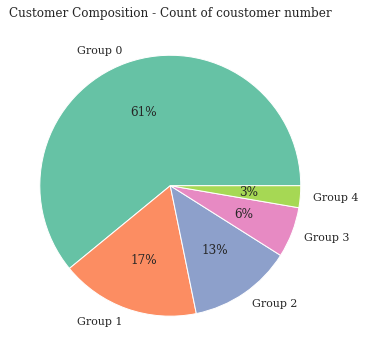

In [33]:
#-Visualize the population ratio of each cluster
com = purchase_data.Cluster.value_counts()
com_df = pd.DataFrame(com)

plt.figure(figsize = (6,6))
plt.rcParams['font.family'] = "serif"
plt.title('Customer Composition - Count of coustomer number')

label = ['Group 0','Group 1','Group 2','Group 3','Group 4']
plt.pie(com, labels=label,autopct='%.0f%%')
plt.show()

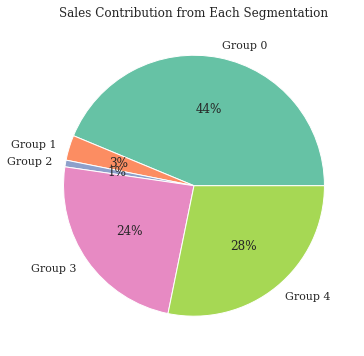

In [34]:
#-Visualize the Monetary contribution from each cluster

m = purchase_data.groupby('Cluster').Monetary.sum()
m_df = pd.DataFrame(m)

plt.figure(figsize = (6,6))
plt.rcParams['font.family'] = "serif"
plt.title('Sales Contribution from Each Segmentation')

label = ['Group 0','Group 1','Group 2','Group 3','Group 4']
plt.pie(m, labels=label,autopct='%.0f%%')
plt.show()

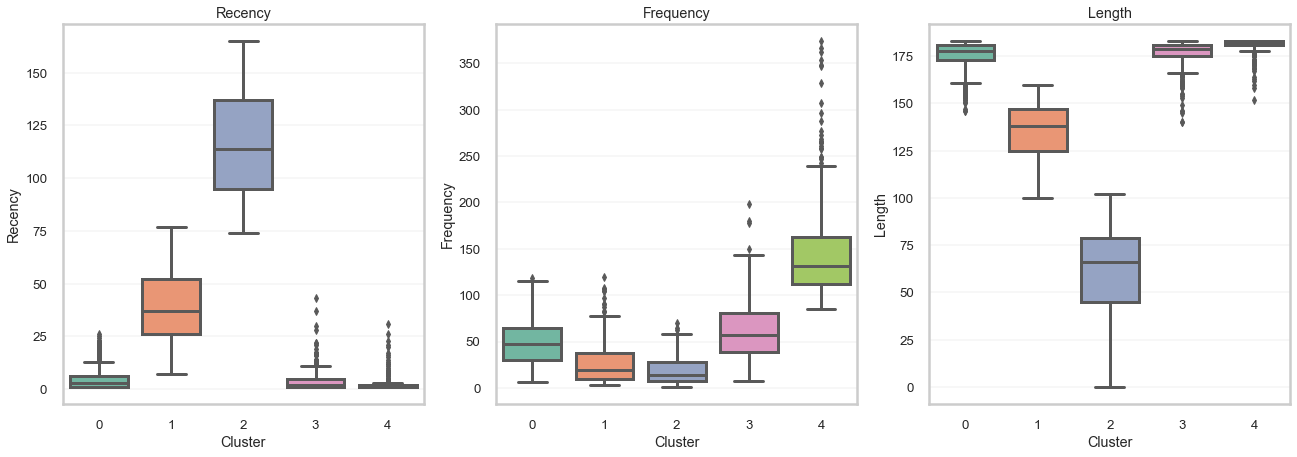

In [35]:
# Statistical Overview 

sns.set_theme(style="whitegrid",palette="Set2")
sns.set_context("poster", font_scale = .6, rc={"grid.linewidth": 0.3})

f, axes = plt.subplots(1, 3,figsize=(22,7))
sns.boxplot(y="Recency", x= "Cluster", data=purchase_data,  orient='v' , ax=axes[0]).set_title('Recency')

sns.boxplot(y="Frequency", x= "Cluster", data=purchase_data,  orient='v' , ax=axes[1]).set_title('Frequency')
sns.boxplot(y="Length", x= "Cluster", data=purchase_data,  orient='v' , ax=axes[2]).set_title('Length');

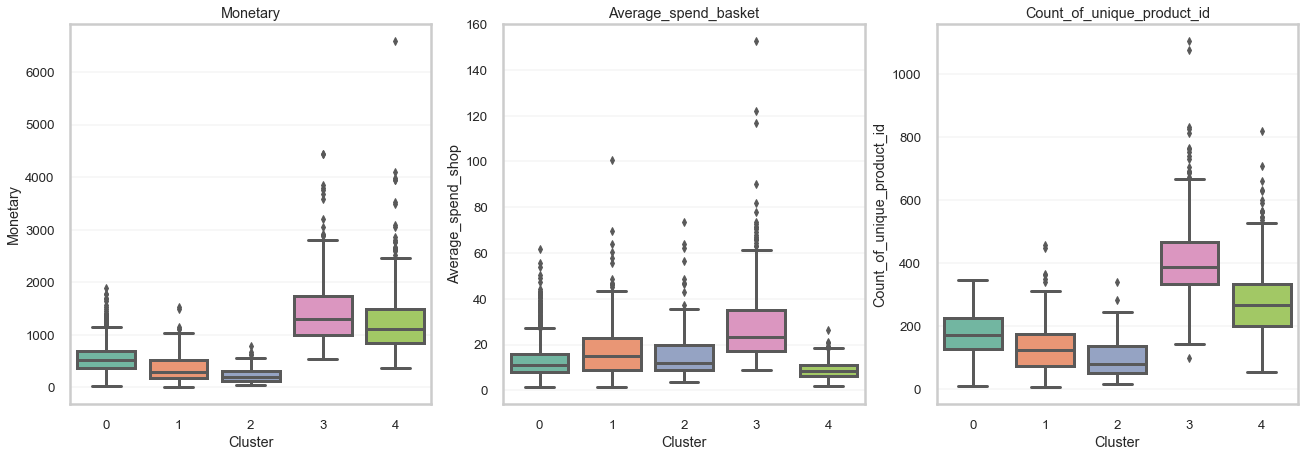

In [36]:
f, axes = plt.subplots(1, 3,figsize=(22,7))
sns.boxplot(y="Monetary", x= "Cluster", data=purchase_data,  orient='v' , ax=axes[0]).set_title('Monetary')

sns.boxplot(y="Average_spend_shop", x= "Cluster", data=purchase_data,  orient='v' , ax=axes[1]).set_title('Average_spend_basket')
sns.boxplot(y="Count_of_unique_product_id", x= "Cluster", data=purchase_data,  orient='v' , ax=axes[2]).set_title('Count_of_unique_product_id');

In [37]:
# Comparison Table
# Median values of each group

purchase_data.groupby('Cluster').median()

,Recency,Frequency,Monetary,Length,Average_spend_shop,Count_of_unique_product_id
Cluster,,,,,,
0,3.0,47.0,521.720,178.0,11.285238,171.0
1,37.0,19.0,294.555,138.0,14.949545,124.0
2,114.0,14.0,194.220,66.0,12.023333,80.0
3,2.0,57.0,1301.160,179.0,23.259192,388.0
4,1.0,132.0,1109.285,182.0,8.405484,267.0


In [38]:
#Statictial summary of customer base

purchase_data.describe()

,Recency,Frequency,Monetary,Length,Average_spend_shop,Count_of_unique_product_id,Cluster
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,9.120333,65.182333,769.781613,171.242000,14.805957,218.750000,1.192333
std,20.938847,47.464717,552.984742,22.456733,11.160582,121.516911,1.633268
min,1.000000,1.000000,7.280000,0.000000,1.456000,6.000000,0.000000
25%,1.000000,32.000000,406.707500,172.000000,8.039984,135.000000,0.000000
50%,3.000000,53.000000,627.170000,178.000000,11.770923,195.500000,0.000000
75%,7.000000,86.000000,958.660000,181.000000,17.436190,278.000000,3.000000
max,165.000000,374.000000,6588.650000,183.000000,152.621667,1106.000000,4.000000


In [39]:
#Creat a CSV file containing cluster results and customer number

purchase_data.to_csv('cluster_results')